<a href="https://colab.research.google.com/github/avani1998/ECE-6123-Image-and-Video-Processing/blob/main/homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import os
import torch
from torchvision import datasets, transforms,models
from torch import nn, optim
from PIL import Image
import shutil
import random
from torch.autograd import Function, Variable

%matplotlib inline

In [ ]:
drive.mount('/content/drive/')
!unzip /content/drive/MyDrive/PennFudanPed.zip

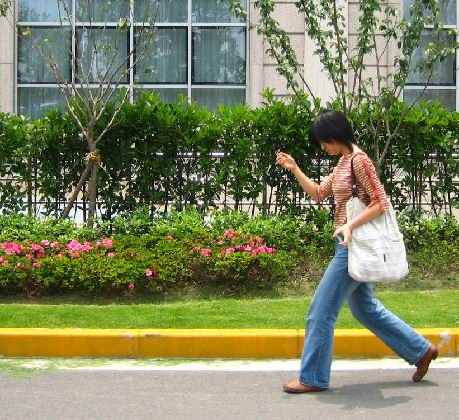

In [3]:
Image.open('/content/PennFudanPed/PNGImages/FudanPed00011.png')

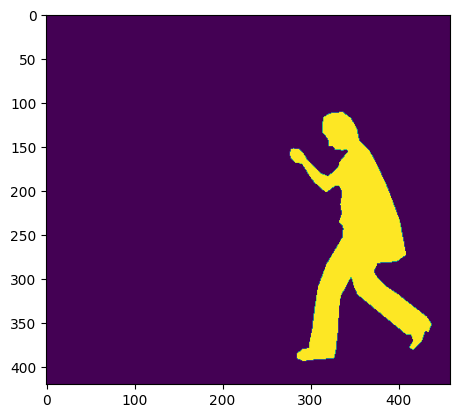

In [4]:
mask_show = plt.imread('/content/PennFudanPed/PedMasks/FudanPed00011_mask.png')
plt.imshow(mask_show)

### Creating custom dataset

In [5]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path)
        #mask = np.array(mask)
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        #obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        if self.transforms is not None:
            # img, target = self.transforms(img, target)
            img = self.transforms(img)
            mask = self.transforms(mask)

        return img, mask

    def __len__(self):
        return len(self.imgs)

In [6]:
# %%shell
# rm -rf "/content/train/PNGImages"
# rm -rf "/content/train/PedMasks"

# rm -rf "/content/val/PNGImages"
# rm -rf "/content/val/PedMasks"

# rm -rf "/content/test/PNGImages"
# rm -rf "/content/test/PedMasks"

In [7]:
%%shell 
mkdir "/content/train"
mkdir "/content/train/PNGImages"
mkdir "/content/train/PedMasks"
mkdir "/content/val"
mkdir "/content/val/PNGImages"
mkdir "/content/val/PedMasks"
mkdir "/content/test"
mkdir "/content/test/PNGImages"
mkdir "/content/test/PedMasks"

### (a) 
Cut the FudanPed dataset into an 80-10-10 train-val-test split.

In [8]:
# Set the source directories for the images and masks
image_dir = "/content/PennFudanPed/PNGImages"
mask_dir = "/content/PennFudanPed/PedMasks"
# Set the destination directories for the train, validation, and test sets
train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

# Get the list of all image files in the image directory
all_images = os.listdir(image_dir)
# Shuffle the image files randomly
random.shuffle(all_images)

# Calculate the number of samples for each split
total_samples = len(all_images)
train_samples = int(0.8 * total_samples)
val_samples = int(0.1 * total_samples)
test_samples = int(0.1 * total_samples)

# Copy the images and masks to respective train, validation, and test directories
for i, image in enumerate(all_images):
    image_path = os.path.join(image_dir, image)
    mask_path = os.path.join(mask_dir, image.replace(".png", "_mask.png"))
    if i < train_samples:
        shutil.copyfile(image_path, os.path.join(train_dir+"/PNGImages", image))
        shutil.copyfile(mask_path, os.path.join(train_dir+"/PedMasks", image.replace(".png", "_mask.png")))
    elif i < train_samples + val_samples:
        shutil.copyfile(image_path, os.path.join(val_dir+"/PNGImages", image))
        shutil.copyfile(mask_path, os.path.join(val_dir+"/PedMasks", image.replace(".png", "_mask.png")))
    else:
        shutil.copyfile(image_path, os.path.join(test_dir+"/PNGImages", image))
        shutil.copyfile(mask_path, os.path.join(test_dir+"/PedMasks", image.replace(".png", "_mask.png")))

print("Dataset split completed successfully!")

Dataset split completed successfully!


### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

In [9]:
train_transform = transforms.Compose([transforms.Resize((128,128)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor()])
val_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

In [10]:
train_dataset = PennFudanDataset("/content/train",transforms=train_transform)
val_dataset = PennFudanDataset("/content/val",transforms=val_transform)
test_dataset = PennFudanDataset("/content/test",transforms=test_transform)

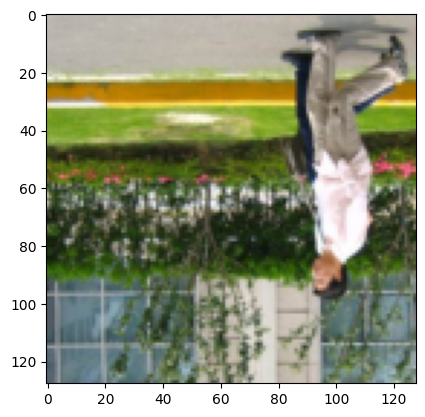

In [11]:
img=Image.open("/content/PennFudanPed/PNGImages/FudanPed00010.png") #PIL image
transformed_img=train_transform(img)  #apply transform
augmented_image = transforms.ToPILImage()(transformed_img)  #convert tensor back to PIL image since shape of image is (1,256,256)
plt.imshow(augmented_image)

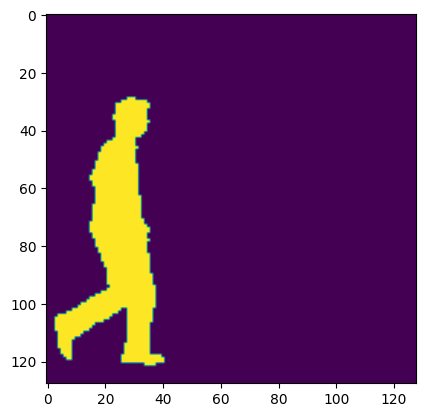

In [12]:
img=Image.open("/content/PennFudanPed/PedMasks/FudanPed00010_mask.png") #PIL image
transformed_img=train_transform(img)  #apply transform
augmented_image = transforms.ToPILImage()(transformed_img)  #convert tensor back to PIL image since shape of image is (1,256,256)
plt.imshow(augmented_image)

### (c) 
Implement and train a CNN for binary segmentation on your train split. Describe your network architecture, loss function, and any training hyper-parameters. You may implement any architecture you'd like, but the implementation must be your own code.

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [14]:
class single_conv(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 3),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(down, self).__init__()
        self.down = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv = single_conv(in_dim, out_dim) 
    def forward(self, x):
        x = self.down(x)
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(up, self).__init__()       
        self.up = nn.Upsample(mode='bilinear', scale_factor=2) 
        self.conv = single_conv(in_dim, out_dim) 
    def forward(self, x1, x2):
        
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class outconv(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, 3)

    def forward(self, x):
        x = self.conv(x)
        return x

In [15]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = single_conv(n_channels, 16) # conv2d +  batchnorm + relu
        self.down1 = down(16, 32)         # maxpool2d + conv2d + batchnorm + relu
        self.down2 = down(32, 32)         # maxpool2d + conv2d + batchnorm + relu

        self.up1 = up(64, 16)             # upsample + pad + conv2d + batchnorm + relu
        self.up2 = up(32, 16)             # upsample + pad + conv2d + batchnorm + relu

        self.outc = outconv(16, 1)        # conv2d

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x = self.up1(x3, x2)
        x = self.up2(x, x1)

        x = self.outc(x)
        return torch.nn.functional.sigmoid(x)
    

In [16]:
model = UNet(3,1)


epochs = 40
lr = 0.0001
batch_size=8

criterion = nn.BCELoss()  #Binary cross entropy loss 
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)

In [17]:
print(next(iter(train_loader)))

[tensor([[[[0.4275, 0.4431, 0.5529,  ..., 0.7569, 0.6824, 0.6824],
          [0.7882, 0.8157, 0.8353,  ..., 0.7647, 0.5961, 0.5608],
          [0.9216, 0.9216, 0.9098,  ..., 0.8353, 0.6706, 0.5137],
          ...,
          [0.6118, 0.5725, 0.5216,  ..., 0.3804, 0.1686, 0.1255],
          [0.3647, 0.3529, 0.3294,  ..., 0.2667, 0.1569, 0.1098],
          [0.3961, 0.3843, 0.3804,  ..., 0.1608, 0.1490, 0.1059]],

         [[0.4039, 0.4314, 0.5608,  ..., 0.6157, 0.5569, 0.5765],
          [0.7608, 0.8000, 0.8392,  ..., 0.6235, 0.4745, 0.4549],
          [0.8902, 0.9059, 0.9137,  ..., 0.6941, 0.5490, 0.4078],
          ...,
          [0.5608, 0.5294, 0.4824,  ..., 0.4706, 0.2667, 0.2235],
          [0.3451, 0.3333, 0.3176,  ..., 0.3608, 0.2510, 0.2039],
          [0.4078, 0.4039, 0.3961,  ..., 0.2471, 0.2353, 0.1804]],

         [[0.3804, 0.4039, 0.5294,  ..., 0.5373, 0.4941, 0.5216],
          [0.7373, 0.7725, 0.8078,  ..., 0.5490, 0.4078, 0.4000],
          [0.8706, 0.8784, 0.8824,  ..., 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(epochs):
 
  for i, (images, masks) in enumerate(train_loader):
    # Zero the gradients
    optimizer.zero_grad()

    images,masks = images.to(device),masks.to(device)
    
    # Forward pass
    outputs = model(images)
    
    # Compute loss
    outputs = torch.nn.functional.interpolate(outputs, size=(128, 128), mode='bilinear', align_corners=True)
    loss = criterion(outputs, masks)
    
    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    # Print training progress
    print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'
          .format(epoch + 1, epochs, i + 1, len(train_loader), loss.item()))

### (d) 

Report training loss, validation loss, and validation DICE curves. Comment on any over fitting or under fitting observed.

In [20]:
class DiceCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001 # in case union = 0
        self.inter = torch.sum(input*target) # Instruction looks strange
        self.union = torch.sum(input) + torch.sum(target) + eps
        # Calculate DICE 
        d = self.inter/self.union
        return d

def dice_coeff(input, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()
        
    # For each pair of input and target, call DiceCoeff().forward(input, target) to calculate dice coefficient
    # Then average
    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff.forward(c[0], c[1]) 
    s = s / (i + 1)
    return s